In [1]:
import requests
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

comm = pd.read_csv('nLEtkmVUMfU_csv_final.csv',encoding='utf8',error_bad_lines=False, index_col=0)
comm.head()

,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating
0,Mann kann sich hier bei arte einfach keine Kom...,UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,2020-08-05T15:17:10Z,none
1,Da wird die Menschheit aber ziemlich schlecht ...,UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,2020-08-05T12:31:25Z,none
2,Man könnte denken aliens haben diese doku zur ...,UgxSWsFbsl8oyxH1XS54AaABAg,1,0,2020-08-05T11:47:53Z,none
3,Das ist doch Rassismus gegen Menschen 🤣🤣,Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,2020-08-05T11:47:30Z,none
4,Genauso sollte das unseren Kindern in der Schu...,UgxuhuYgvks80mBmY1N4AaABAg,0,0,2020-08-05T10:39:19Z,none


In [2]:
# Test
TextBlob('This video is awesome!').sentiment

Sentiment(polarity=1.0, subjectivity=1.0)

In [3]:
TextBlob('This video sucks').sentiment

Sentiment(polarity=-0.3, subjectivity=0.3)

In [4]:
comm.info

<bound method DataFrame.info of                                                Comments  \
0     Mann kann sich hier bei arte einfach keine Kom...   
1     Da wird die Menschheit aber ziemlich schlecht ...   
2     Man könnte denken aliens haben diese doku zur ...   
3              Das ist doch Rassismus gegen Menschen 🤣🤣   
4     Genauso sollte das unseren Kindern in der Schu...   
...                                                 ...   
3212  Der Mensch muss sich über das ganze Universum ...   
3213  Sehr interessant.\nVielen Dank für eure tollen...   
3214  Der Mensch ist das schlimmste aller Tiere!\nVe...   
3215                    Arte de ist kacke war nur spass   
3216  Der Mensch ist Schöpfer Gottes\n-Ludwig Feuerbach   

                      Comment ID  Reply Count  Like Count  \
0     UgwF0k_LPwxgDyd2mTZ4AaABAg            0           0   
1     UgxQUQHM83Hw2PMW5Gl4AaABAg            1           0   
2     UgxSWsFbsl8oyxH1XS54AaABAg            1           0   
3     Ugw3ke-Mt

In [5]:
comm.shape

(3217, 6)

## Data Preprocessing

### Lowercase comments
Lowercasing comments to avoid being treated as two different words

In [6]:
comm['Comments'] = comm['Comments'].str.lower()
comm['Comments'].head()

0    mann kann sich hier bei arte einfach keine kom...
1    da wird die menschheit aber ziemlich schlecht ...
2    man könnte denken aliens haben diese doku zur ...
3             das ist doch rassismus gegen menschen 🤣🤣
4    genauso sollte das unseren kindern in der schu...
Name: Comments, dtype: object

### Remove trailing spaces from comments

In [7]:
comm['Comments'] = comm['Comments'].str.strip()

In [8]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/kim-
[nltk_data]     chido/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kim-chido/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Remove urls

In [9]:
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re, string
import regex
import emoji
import dateutil.parser
import spacy
import json


# r'S' matches anything until next whitespace
def remove_urls(text):
    return re.sub(r'https?://\S+', '', text)

In [10]:
stripped_urls = [remove_urls(comment) for comment in comm['Comments'].values]

In [11]:
unique_comments = Counter(stripped_urls)
print(unique_comments[''])

6


In [12]:
comm['Stripped_urls'] = [remove_urls(comment) for comment in comm['Comments'].values]

## Emojis
Temporarily strip emojis for language detection

In [13]:
import demoji
demoji.download_codes()

... OK (Got response in 0.38 seconds)
Writing emoji data to /Users/kim-chido/.demoji/codes.json ...
... OK


In [14]:
demoji.replace("🥺hey what's up", "")


"hey what's up"

In [15]:
comm['Stripped_emojis'] = [demoji.replace(comment) for comment in comm['Stripped_urls']]

In [16]:
pure_urls_and_emojis = len(comm[comm['Stripped_emojis'] == '' ])
pure_urls_and_emojis

13

In [17]:
comm.head()

,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating,Stripped_urls,Stripped_emojis
0,mann kann sich hier bei arte einfach keine kom...,UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,2020-08-05T15:17:10Z,none,mann kann sich hier bei arte einfach keine kom...,mann kann sich hier bei arte einfach keine kom...
1,da wird die menschheit aber ziemlich schlecht ...,UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,2020-08-05T12:31:25Z,none,da wird die menschheit aber ziemlich schlecht ...,da wird die menschheit aber ziemlich schlecht ...
2,man könnte denken aliens haben diese doku zur ...,UgxSWsFbsl8oyxH1XS54AaABAg,1,0,2020-08-05T11:47:53Z,none,man könnte denken aliens haben diese doku zur ...,man könnte denken aliens haben diese doku zur ...
3,das ist doch rassismus gegen menschen 🤣🤣,Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,2020-08-05T11:47:30Z,none,das ist doch rassismus gegen menschen 🤣🤣,das ist doch rassismus gegen menschen
4,genauso sollte das unseren kindern in der schu...,UgxuhuYgvks80mBmY1N4AaABAg,0,0,2020-08-05T10:39:19Z,none,genauso sollte das unseren kindern in der schu...,genauso sollte das unseren kindern in der schu...


In [18]:
# drop columns
comm.drop(columns=['Updated At', 'Viewer Rating'])


,Comments,Comment ID,Reply Count,Like Count,Stripped_urls,Stripped_emojis
0,mann kann sich hier bei arte einfach keine kom...,UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,mann kann sich hier bei arte einfach keine kom...,mann kann sich hier bei arte einfach keine kom...
1,da wird die menschheit aber ziemlich schlecht ...,UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,da wird die menschheit aber ziemlich schlecht ...,da wird die menschheit aber ziemlich schlecht ...
2,man könnte denken aliens haben diese doku zur ...,UgxSWsFbsl8oyxH1XS54AaABAg,1,0,man könnte denken aliens haben diese doku zur ...,man könnte denken aliens haben diese doku zur ...
3,das ist doch rassismus gegen menschen 🤣🤣,Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,das ist doch rassismus gegen menschen 🤣🤣,das ist doch rassismus gegen menschen
4,genauso sollte das unseren kindern in der schu...,UgxuhuYgvks80mBmY1N4AaABAg,0,0,genauso sollte das unseren kindern in der schu...,genauso sollte das unseren kindern in der schu...
...,...,...,...,...,...,...
3212,der mensch muss sich über das ganze universum ...,UgzZ7291xNPCAVQm8yt4AaABAg,2,6,der mensch muss sich über das ganze universum ...,der mensch muss sich über das ganze universum ...
3213,sehr interessant.\nvielen dank für eure tollen...,UgyodpnYUrj2ZrIEGAx4AaABAg,0,3,sehr interessant.\nvielen dank für eure tollen...,sehr interessant.\nvielen dank für eure tollen...
3214,der mensch ist das schlimmste aller tiere!\nve...,Ugxi6bSuc3iz_1eIF854AaABAg,4,14,der mensch ist das schlimmste aller tiere!\nve...,der mensch ist das schlimmste aller tiere!\nve...
3215,arte de ist kacke war nur spass,Ugxo9KnZADKJu46a6CB4AaABAg,0,0,arte de ist kacke war nur spass,arte de ist kacke war nur spass


## Calculate Sentiment Polarity for each comment
Add new feature for polarity

In [19]:
pol=[] # list containing the polarity of the comments
for i in comm.Comments.values:
    try:
        analysis =TextBlob(i)
        pol.append(analysis.sentiment.polarity)
        
    except:
        pol.append(0)

In [20]:
comm['polarity']=comm['Comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [21]:
comm.head()

,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating,Stripped_urls,Stripped_emojis,polarity
0,mann kann sich hier bei arte einfach keine kom...,UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,2020-08-05T15:17:10Z,none,mann kann sich hier bei arte einfach keine kom...,mann kann sich hier bei arte einfach keine kom...,0.0
1,da wird die menschheit aber ziemlich schlecht ...,UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,2020-08-05T12:31:25Z,none,da wird die menschheit aber ziemlich schlecht ...,da wird die menschheit aber ziemlich schlecht ...,0.0
2,man könnte denken aliens haben diese doku zur ...,UgxSWsFbsl8oyxH1XS54AaABAg,1,0,2020-08-05T11:47:53Z,none,man könnte denken aliens haben diese doku zur ...,man könnte denken aliens haben diese doku zur ...,-0.1
3,das ist doch rassismus gegen menschen 🤣🤣,Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,2020-08-05T11:47:30Z,none,das ist doch rassismus gegen menschen 🤣🤣,das ist doch rassismus gegen menschen,0.0
4,genauso sollte das unseren kindern in der schu...,UgxuhuYgvks80mBmY1N4AaABAg,0,0,2020-08-05T10:39:19Z,none,genauso sollte das unseren kindern in der schu...,genauso sollte das unseren kindern in der schu...,0.0


In [22]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

comm['Stripped_emojis'].apply(word_tokenize)


0       [mann, kann, sich, hier, bei, arte, einfach, k...
1       [da, wird, die, menschheit, aber, ziemlich, sc...
2       [man, könnte, denken, aliens, haben, diese, do...
3            [das, ist, doch, rassismus, gegen, menschen]
4       [genauso, sollte, das, unseren, kindern, in, d...
                              ...                        
3212    [der, mensch, muss, sich, über, das, ganze, un...
3213    [sehr, interessant, ., vielen, dank, für, eure...
3214    [der, mensch, ist, das, schlimmste, aller, tie...
3215              [arte, de, ist, kacke, war, nur, spass]
3216    [der, mensch, ist, schöpfer, gottes, -ludwig, ...
Name: Stripped_emojis, Length: 3217, dtype: object

In [23]:
comm.tail()

,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating,Stripped_urls,Stripped_emojis,polarity
3212,der mensch muss sich über das ganze universum ...,UgzZ7291xNPCAVQm8yt4AaABAg,2,6,2019-05-19T13:06:55Z,none,der mensch muss sich über das ganze universum ...,der mensch muss sich über das ganze universum ...,0.0
3213,sehr interessant.\nvielen dank für eure tollen...,UgyodpnYUrj2ZrIEGAx4AaABAg,0,3,2019-05-19T13:06:19Z,none,sehr interessant.\nvielen dank für eure tollen...,sehr interessant.\nvielen dank für eure tollen...,0.0
3214,der mensch ist das schlimmste aller tiere!\nve...,Ugxi6bSuc3iz_1eIF854AaABAg,4,14,2019-05-19T13:11:45Z,none,der mensch ist das schlimmste aller tiere!\nve...,der mensch ist das schlimmste aller tiere!\nve...,0.0
3215,arte de ist kacke war nur spass,Ugxo9KnZADKJu46a6CB4AaABAg,0,0,2019-05-19T13:04:51Z,none,arte de ist kacke war nur spass,arte de ist kacke war nur spass,0.0
3216,der mensch ist schöpfer gottes\n-ludwig feuerbach,UgwDIZyMaaCxVf21JSd4AaABAg,13,43,2019-05-19T13:05:34Z,none,der mensch ist schöpfer gottes\n-ludwig feuerbach,der mensch ist schöpfer gottes\n-ludwig feuerbach,0.0


In [24]:
comm.shape

(3217, 9)

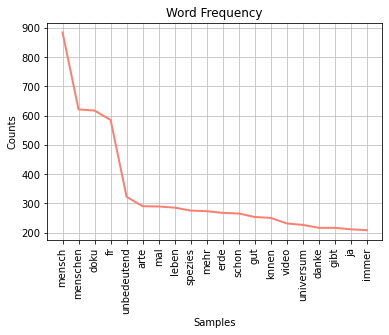

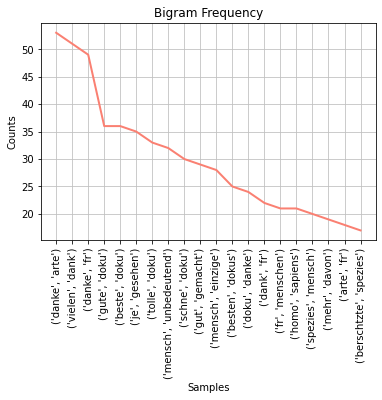

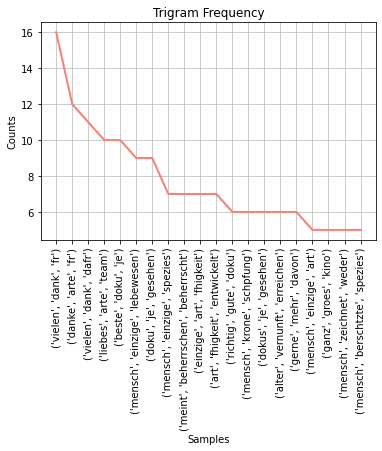

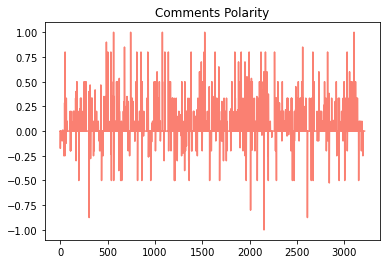

In [25]:
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
#Import packages and data
import pandas as pd
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob

df=pd.read_csv('nLEtkmVUMfU_csv_final.csv')

##### DATA CLEANING ########
sw = stopwords.words('german')

def clean_text(text):

    text = text.lower()
    text = re.sub('@', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z ]+", "", text)
    
    #Tokenize the data
    text = nltk.word_tokenize(text)
    #Remove stopwords
    text = [w for w in text if w not in sw]

    return text

# Applying the cleaning function to data
df['Comments'] = df['Comments'].apply(lambda x: clean_text(x))


#Lemmatizer
lemmatizer = WordNetLemmatizer()
def lem(text):
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [lemmatizer.lemmatize(t, 'v') for t in text]

    return text

df['Comments'] = df['Comments'].apply(lambda x: lem(x))


#Remove all empty comments
empty_comment = df['Comments'][1459]

for i in range(len(df)):
    if df['Comments'][i]==empty_comment:
        df=df.drop(i)

df=df.reset_index(drop=True)

######### ANALYSIS ########

#From lists to single list       
all_words=[]        
for i in range(len(df)):
    all_words = all_words + df['Comments'][i]


#Get word frequency        
nlp_words = nltk.FreqDist(all_words)
nlp_words.plot(20, color='salmon', title='Word Frequency')

#Bigrams
bigrm = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigrm)
words_2.plot(20, color='salmon', title='Bigram Frequency')

#Trigrams
trigrm = list(nltk.trigrams(all_words))
words_3 = nltk.FreqDist(trigrm)
words_3.plot(20, color='salmon', title='Trigram Frequency')


#Get sentiment from comments
df['Comments'] = [str(thing) for thing in df['Comments']]

polarity=[] # list containing the polarity of the comments
for i in range(len(df)):
    blob = TextBlob(df['Comments'][i])
    for sentence in blob.sentences:
        polarity.append(sentence.sentiment.polarity)

        
sentiment = []
for i in range(len(df)):
    blob = TextBlob(df['Comments'][i])
    for sentence in blob.sentences:
        sentiment.append(sentence.sentiment.polarity)
        
df['polarity']= polarity
df['sentiment']=sentiment
df['sentiment'].plot(color='salmon', title='Comments Polarity')
        

In [26]:
#Basic stats
df['sentiment'].describe()
nlp_words['mensch']

884

In [27]:
df.head()

,Unnamed: 0,Comments,Comment ID,Reply Count,Like Count,Updated At,Viewer Rating,polarity,sentiment
0,0,"['mann', 'arte', 'einfach', 'kommentare', 'meh...",UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,2020-08-05T15:17:10Z,none,0.000,0.000
1,1,"['menschheit', 'ziemlich', 'schlecht', 'gemach...",UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,2020-08-05T12:31:25Z,none,0.000,0.000
2,2,"['knnte', 'denken', 'alien', 'doku', 'propagan...",UgxSWsFbsl8oyxH1XS54AaABAg,1,0,2020-08-05T11:47:53Z,none,-0.175,-0.175
3,3,"['rassismus', 'menschen']",Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,2020-08-05T11:47:30Z,none,0.000,0.000
4,4,"['genauso', 'kindern', 'schule', 'vermittelt',...",UgxuhuYgvks80mBmY1N4AaABAg,0,0,2020-08-05T10:39:19Z,none,0.000,0.000


In [28]:
df.drop(columns=['Updated At', 'Viewer Rating'], inplace=True)
df.head(3)

,Unnamed: 0,Comments,Comment ID,Reply Count,Like Count,polarity,sentiment
0,0,"['mann', 'arte', 'einfach', 'kommentare', 'meh...",UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,0.000,0.000
1,1,"['menschheit', 'ziemlich', 'schlecht', 'gemach...",UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,0.000,0.000
2,2,"['knnte', 'denken', 'alien', 'doku', 'propagan...",UgxSWsFbsl8oyxH1XS54AaABAg,1,0,-0.175,-0.175


In [29]:
df['polarity'][df.polarity==0]= 0
df['polarity'][df.polarity > 0]= 1
df['polarity'][df.polarity < 0]= -1

In [30]:
df.head()

,Unnamed: 0,Comments,Comment ID,Reply Count,Like Count,polarity,sentiment
0,0,"['mann', 'arte', 'einfach', 'kommentare', 'meh...",UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,0.0,0.000
1,1,"['menschheit', 'ziemlich', 'schlecht', 'gemach...",UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,0.0,0.000
2,2,"['knnte', 'denken', 'alien', 'doku', 'propagan...",UgxSWsFbsl8oyxH1XS54AaABAg,1,0,-1.0,-0.175
3,3,"['rassismus', 'menschen']",Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,0.0,0.000
4,4,"['genauso', 'kindern', 'schule', 'vermittelt',...",UgxuhuYgvks80mBmY1N4AaABAg,0,0,0.0,0.000


 0.0    2717
 1.0     381
-1.0     116
Name: polarity, dtype: int64

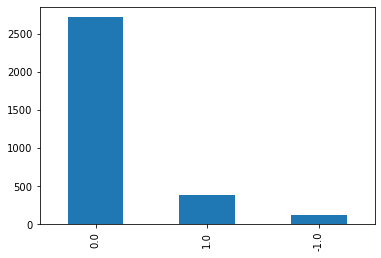

In [31]:
df.polarity.value_counts().plot.bar()
df.polarity.value_counts()

In [32]:
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages)) # See which languages are supported


arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [33]:

stemmer = SnowballStemmer("german") 
def stemming(words):
    new = []
    stem_words = [snowball.stem(x) for x in (words[:][0])]
    new.append(stem_words)
    return new

In [34]:
df.head()

,Unnamed: 0,Comments,Comment ID,Reply Count,Like Count,polarity,sentiment
0,0,"['mann', 'arte', 'einfach', 'kommentare', 'meh...",UgwF0k_LPwxgDyd2mTZ4AaABAg,0,0,0.0,0.000
1,1,"['menschheit', 'ziemlich', 'schlecht', 'gemach...",UgxQUQHM83Hw2PMW5Gl4AaABAg,1,0,0.0,0.000
2,2,"['knnte', 'denken', 'alien', 'doku', 'propagan...",UgxSWsFbsl8oyxH1XS54AaABAg,1,0,-1.0,-0.175
3,3,"['rassismus', 'menschen']",Ugw3ke-MtlziI1zPFjR4AaABAg,0,0,0.0,0.000
4,4,"['genauso', 'kindern', 'schule', 'vermittelt',...",UgxuhuYgvks80mBmY1N4AaABAg,0,0,0.0,0.000


In [35]:
df['Comments'].to_csv('comments_matrix.csv')


In [36]:
comment_string = " ".join(comment for comment in df["Comments"])

In [37]:
unique_frequencies = dict()
total_frequencies = dict()
for word in comments:
    word = nltk.word_tokenize(comments)
    fdist = nltk.FreqDist(comments)
    for word, freq in fdist.most_common(50):
        total_frequencies[word] += freq # total count
        unique_frequencies[word] += 1 # unique count

NameError: name 'comments' is not defined

In [ ]:
#df.to_csv('NLP_analysis.csv', index=False)

## Build a Model

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Comments'],df['polarity'], test_size = 0.2, random_state = 324)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vect= CountVectorizer()
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [42]:
tf_train.shape

(2571, 11814)

In [43]:
vect.vocabulary_

{'en': 2800,
 'mer': 6838,
 'wrde': 11407,
 'usamen': 10269,
 'sts': 9416,
 'erstmal': 3178,
 'vorweg': 10888,
 'super': 9463,
 'schne': 8576,
 'doku': 2343,
 'gerhrt': 4195,
 'zugleich': 11679,
 'einfach': 2626,
 'geflasht': 3938,
 'ganz': 3836,
 'groes': 4623,
 'kino': 5709,
 'wissen': 11317,
 'vermittelt': 10511,
 'knackigen': 5799,
 'minutendennoch': 6937,
 'menschen': 6783,
 'ausmacht': 884,
 'wer': 11121,
 'sammeln': 8386,
 'material': 6675,
 'zusammen': 11719,
 'bauen': 1011,
 'ob': 7477,
 'rakete': 8046,
 'mond': 7041,
 'handy': 4800,
 'komunikation': 5929,
 'via': 10689,
 'telefonnetz': 9572,
 'internet': 5415,
 'glaube': 4448,
 'mensch': 6777,
 'mischung': 6947,
 'tieren': 9671,
 'leider': 6351,
 'schade': 8422,
 'planeten': 7778,
 'zugrunde': 11681,
 'richten': 8265,
 'tiefsten': 9664,
 'respekt': 8232,
 'groartigen': 4613,
 'produktion': 7914,
 'mitgewirkt': 6971,
 'kunstwerk': 6144,
 'fr': 3688,
 'ewigkeit': 3287,
 'fall': 3375,
 'standardwerk': 9242,
 'schler': 8517,
 'we

## Sentiment Classification
Use an LR Algorithm for classification.
Logistic Regression will help in predicting the probability of outcomes i.e. binary classification or multi-classification. Examples of logistic regression include spam classifier, customer churn prediction, tumor prediction, etc.

 

These are some of the famous examples of the same, while you can apply the same for other cases as in this instance of sentiment analysis, where there are two classes to classify i.e. either positive (1) or negative (-1).

 

The scikit learn will be utilized to implement logistic regression for the sentiment classification. 

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(tf_train, y_train)

LogisticRegression()

In [45]:
lr.score(tf_train, y_train)

0.9918319719953326

In [46]:
lr.score(tf_test, y_test)

0.9237947122861586

#### Make predictions on the test dataset by using a model trained above:

In [47]:
expected = y_test
predicted = lr.predict(tf_test)

In [51]:
>>> from sklearn.metrics import accuracy_score


print(accuracy_score(y_test, predicted))

0.9237947122861586


### Confusion Matrix

In [52]:
import sklearn.metrics as metrics
cf=metrics.confusion_matrix(expected, predicted, labels = [1,-1])
cf

array([[59,  1],
       [ 1,  2]])

In [53]:
from sklearn import metrics
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

        -1.0       0.50      0.07      0.13        27
         0.0       0.92      1.00      0.96       534
         1.0       0.98      0.72      0.83        82

    accuracy                           0.92       643
   macro avg       0.80      0.60      0.64       643
weighted avg       0.91      0.92      0.91       643



In [54]:
from sklearn.metrics import f1_score
f1_score(expected, predicted, average='macro')

0.6392633205059803

## Train a Naive Bayes Model

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

NB_model = MultinomialNB()
NB_model.fit(tf_train, y_train)
y_predict_nb = NB_model.predict(tf_test)
print(accuracy_score(y_test, y_predict_nb))



0.8771384136858476


In [56]:
expected = y_test

from sklearn.metrics import f1_score
f1_score(expected, y_predict_nb, average='macro')

0.5654710818109511